### Подготовка данных и вытягивание их из экселя

In [1]:
from datetime import date, timedelta
from typing import Optional

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates



Для начала разберемся со стартовым состояниям склада, потому что там отличается формат

In [2]:
storage_file_path = 'storage.xlsx'
storage_file = pd.ExcelFile(storage_file_path)
sheets = storage_file.sheet_names

storage_data_frame = storage_file.parse(sheets[0], names=['name', 'count'])
storage_data = {
    name: float(count)

    for (name, count) in list(
        zip(
            storage_data_frame['name'],
            storage_data_frame['count']
        )
    )[5:]
}
print(
    f'Всего товаров: {len(storage_data_frame["name"])}'
)
print(
    f'Тест (Биокомфорт для дачных туалетов и септиков 70 гр): {storage_data["Биокомфорт для дачных туалетов и септиков 70 гр,"]}'
)

Всего товаров: 5919
Тест (Биокомфорт для дачных туалетов и септиков 70 гр): 45.0


In [3]:
def get_products_data_from_report(report_path: str) -> dict:
    report_file = pd.ExcelFile(report_path)
    sheets = report_file.sheet_names

    fields = ['art', 'name', 'count', 'unit', 'date']
    report_data_frame = report_file.parse(
        sheets[0],
        names=fields
    )

    def get_dict_from_row(row_index):
        return {
            field: report_data_frame[field][row_index]
            for field in fields
        }

    flat_report_data_frame = list(
        map(
            get_dict_from_row,
            range(len(report_data_frame))
        )
    )

    return {
        name: [
            {
                'date': report_row['date'].date(),
                'count': report_row['count']
            }
            for report_row in flat_report_data_frame
            if report_row['name'] == name
        ]
        for name in report_data_frame['name']
    }

In [4]:
by_file_path = 'by.xlsx'
by_data = get_products_data_from_report(by_file_path)

# Оставляем те которые наиболее активно закупаются
by_data = {
    name: byes
    for name, byes in by_data.items()
    if (len(byes) > 6)
}

In [5]:
sell_file_path = 'sell.xlsx'
sell_data = get_products_data_from_report(sell_file_path)

In [6]:
def dict_equalizer(first: dict, second: dict) -> (dict, dict):
    def filter_dict(processed):
        return {
            key: value
            for key, value in processed.items()
            if (key in first) and (key in second)
        }

    return filter_dict(first), filter_dict(second)


# Оставляем только те продукты которые есть и в by_data и в sell_data
by_data, sell_data = dict_equalizer(by_data, sell_data)

print(
    f'Всего было закуплено разных товаров, {len(by_data)}\n'
    f'Всего было продано разных товаров, {len(sell_data)}'
)

Всего было закуплено разных товаров, 1
Всего было продано разных товаров, 1


In [7]:
def date_range(start: date, stop: date) -> [date]:
    dates = []
    current_date = start
    while current_date < stop:
        dates.append(current_date)
        current_date += timedelta(days=1)
    return dates

In [8]:
date_start = date(2022, 10, 1)
date_end = date(2022, 12, 15)

In [9]:
def tarnsform_to_date_dict(list_dict: [dict]) -> dict:
    return {
        row['date']: row['count']
        for row in list_dict
    }

In [10]:
def get_storage_state(base_storage: float, byes: [dict], sells: [dict]):
    storage_state = [base_storage]
    byes_dict = tarnsform_to_date_dict(byes)
    sells_dict = tarnsform_to_date_dict(sells)

    for current_date in date_range(date_start, date_end):
        new_value = storage_state[-1]

        if current_date in byes_dict:
            new_value += byes_dict[current_date]

        if current_date in sells_dict:
            new_value -= sells_dict[current_date]

        storage_state.append(new_value)

    return storage_state

In [11]:
products = by_data.keys()
print('Наименования учавствующие в выборке: \n',
      "\n".join(products))

Наименования учавствующие в выборке: 
 Кирпич цокольный "Шахтинский КЗ" М125 1нф полнотелый (315шт)


In [12]:
def get_include_key(data: dict, key: str) -> Optional[str]:
    for data_key in data.keys():
        if key in data_key:
            return data_key
    return key


storage_states = {
    product: get_storage_state(
        storage_data[
            get_include_key(
                storage_data,
                product
            )
        ],
        by_data[product],
        sell_data[product]
    )
    for product in products
}

### График количества товара на складе


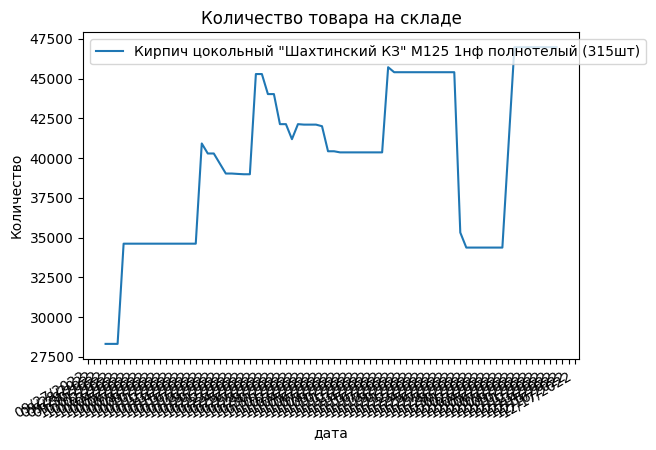

In [13]:
for product in products:
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.plot(
        [date_start - timedelta(days=1)] + date_range(date_start, date_end),
        storage_states[product],

    )
    plt.gcf().autofmt_xdate()

plt.title('Количество товара на складе')
plt.ylabel('Количество')
plt.xlabel('дата')
plt.legend(products, loc='upper left')
plt.show()

In [14]:
def get_by_for_product(by_data: [dict]):
    by = [0.0]
    by_dict = tarnsform_to_date_dict(by_data)

    for current_date in date_range(date_start, date_end):
        if current_date in by_dict:
            by.append(by_dict[current_date])
        else:
            by.append(0.0)

    return by

In [15]:
by_states = {
    product: get_by_for_product(by_data[product])
    for product in products
}

### График закупок

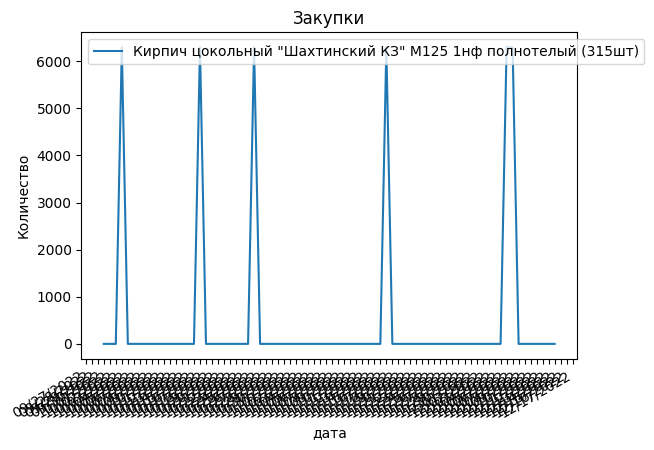

In [16]:
for product in products:
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.plot(
        [date_start - timedelta(days=1)] + date_range(date_start, date_end),
        by_states[product],

    )
    plt.gcf().autofmt_xdate()

plt.title('Закупки')
plt.ylabel('Количество')
plt.xlabel('дата')
plt.legend(products, loc='upper left')
plt.show()

### Подготовка данных для модели и обучение модели

In [17]:
def get_data(states: dict):
    return list(
        zip(
            *np.array([
                np.array(
                    states[product]
                )
                for product in products
            ])
        )
    )

def prepare_x(processed_x):
    dates = [date_start - timedelta(days=1)] + date_range(date_start, date_end)

    prepared_x = []
    for index, current_date in enumerate(dates):
        prepared_x.append(
            np.array([current_date.month, current_date.day] + list(processed_x[index]))
        )

    return np.array(
        prepared_x
    )



data_x = prepare_x(
    get_data(storage_states)
)
data_y = get_data(by_states)

In [18]:
def normalize(data):
    transpose = list(zip(*data))
    maximus = [max(column) for column in transpose]
    return [
        [item / maximus[index] for index, item in enumerate(row)]
        for row in data
    ]


x = normalize(data_x)
y = normalize(data_y)

In [49]:
from keras.layers import Dense
from keras import Sequential, Input

# elu
# softmax
# selu
# softsign
# relu
# sigmoid
# exponential
# linear
model = Sequential()
model.add(Input(3))
model.add(Dense(32, activation='relu'))
# model.add(Dense(16, activation='linear'))
model.add(Dense(8, activation='elu'))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', metrics=['accuracy'], optimizer='adam')


In [58]:
history = model.fit(x, y,
                    batch_size=100,
                    epochs=1000,
                    verbose=1)

Epoch 1/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0629 - accuracy: 0.9211
Epoch 2/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.0628 - accuracy: 0.9211
Epoch 3/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0627 - accuracy: 0.9211
Epoch 4/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0627 - accuracy: 0.9211
Epoch 5/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0627 - accuracy: 0.9211
Epoch 6/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0626 - accuracy: 0.9211
Epoch 7/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0626 - accuracy: 0.9211
Epoch 8/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0626 - accuracy: 0.9211
Epoch 9/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0625 - accuracy: 0.9211
Epoch 10/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0625 - accuracy: 0.9211
Epoch 11/1000
1/1 

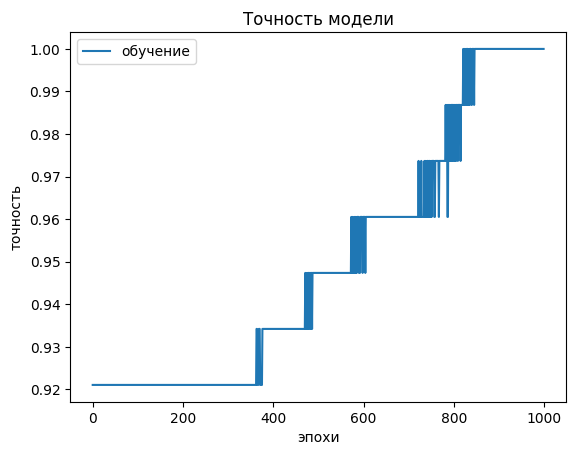

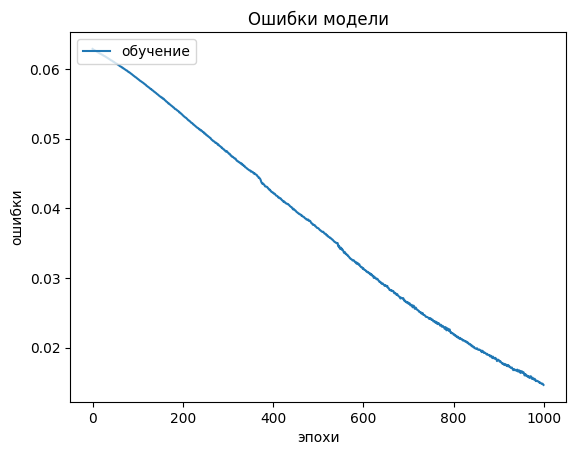

In [59]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.title('Точность модели')
plt.ylabel('точность')
plt.xlabel('эпохи')
plt.legend(['обучение'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.title('Ошибки модели')
plt.ylabel('ошибки')
plt.xlabel('эпохи')
plt.legend(['обучение'], loc='upper left')
plt.show()

In [64]:
predicted = model.predict(data_x)
flatten_predict = [
    predicted_row[0]
    for predicted_row in predicted
]

def normalize_row(row):
    minimum = min(row)
    maximum = max(row)

    return [
        (item - minimum) / maximum
        for item in row
    ]

predicted = normalize_row(flatten_predict)

3/3 [==============================] - 0s 793us/step


In [65]:
print(predicted)

[0.003428308, 0.0, 0.000114195514, 0.13428652, 0.13440086, 0.13451512, 0.13462952, 0.13474406, 0.13485833, 0.13497272, 0.13508712, 0.13520145, 0.13531598, 0.13543032, 0.13554458, 0.13565871, 0.2698313, 0.2565399, 0.25665423, 0.24336252, 0.23007132, 0.23018558, 0.22976775, 0.22945672, 0.22957104, 0.36374357, 0.36385798, 0.3371608, 0.3372752, 0.29717228, 0.29728627, 0.27729207, 0.29385823, 0.29333416, 0.29344827, 0.29356268, 0.29154935, 0.2581493, 0.25826356, 0.2568882, 0.25700247, 0.25711712, 0.25723138, 0.2573462, 0.2574602, 0.25757453, 0.25768885, 0.3717522, 0.36516374, 0.36527786, 0.3653926, 0.3655068, 0.365621, 0.3657358, 0.36585012, 0.36596426, 0.3660788, 0.3661929, 0.36630744, 0.15192896, 0.13193476, 0.1320491, 0.12862079, 0.12873532, 0.12884966, 0.12896365, 0.12907812, 0.26325044, 0.39742264, 0.39753723, 0.39765158, 0.39776585, 0.39788038, 0.39799458, 0.39810884, 0.39822343]


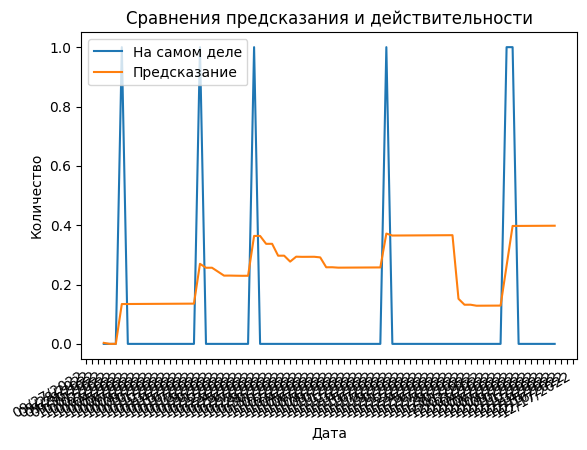

In [66]:
for product_index, product in enumerate(products):
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.plot(
        [date_start - timedelta(days=1)] + date_range(date_start, date_end),
        normalize_row(by_states[product]),

    )
    plt.plot(
        [date_start - timedelta(days=1)] + date_range(date_start, date_end),
        predicted,

    )
    plt.gcf().autofmt_xdate()

    plt.title('Сравнения предсказания и действительности')
    plt.ylabel('Количество')
    plt.xlabel('Дата')
    plt.legend(['На самом деле', 'Предсказание'], loc='upper left')